In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import json


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
import lightgbm as lgb

In [2]:
df = pd.read_csv('earthquake_1995-2023.csv')

In [3]:
df.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,16-08-2023 12:47,7,4,green,0,657,us,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",NaN,Vanuatu
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,19-07-2023 00:22,8,6,yellow,0,775,us,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,"Intipucá, El Salvador",NaN,NaN
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,17-07-2023 03:05,7,5,green,0,899,us,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,"Loncopué, Argentina",South America,Argentina
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,16-07-2023 06:48,6,6,green,1,860,us,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,"Sand Point, Alaska",NaN,NaN
4,M 7.3 - Alaska Peninsula,7.3,16-07-2023 06:48,0,5,NaN,1,820,at,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,Alaska Peninsula,NaN,NaN


In [4]:
df.describe()

,magnitude,cdi,mmi,tsunami,sig,nst,dmin,gap,depth,latitude,longitude
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.940150,3.605000,6.02700,0.325000,847.915000,193.918000,1.125174,20.926290,74.612541,4.315554,51.486576
std,0.438148,3.328972,1.43399,0.468609,301.802632,239.045858,2.073164,24.415895,130.812590,26.633320,117.478302
min,6.500000,0.000000,1.00000,0.000000,650.000000,0.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000
25%,6.600000,0.000000,5.00000,0.000000,691.000000,0.000000,0.000000,0.000000,16.000000,-13.518500,-71.694450
50%,6.800000,4.000000,6.00000,0.000000,744.000000,0.000000,0.000000,18.000000,29.000000,-2.443500,107.791000
75%,7.100000,7.000000,7.00000,1.000000,874.250000,403.000000,1.549250,27.000000,55.000000,25.167250,148.364750
max,9.100000,9.000000,10.00000,1.000000,2910.000000,934.000000,17.654000,239.000000,670.810000,71.631200,179.662000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   date_time  1000 non-null   object 
 3   cdi        1000 non-null   int64  
 4   mmi        1000 non-null   int64  
 5   alert      449 non-null    object 
 6   tsunami    1000 non-null   int64  
 7   sig        1000 non-null   int64  
 8   net        1000 non-null   object 
 9   nst        1000 non-null   int64  
 10  dmin       1000 non-null   float64
 11  gap        1000 non-null   float64
 12  magType    1000 non-null   object 
 13  depth      1000 non-null   float64
 14  latitude   1000 non-null   float64
 15  longitude  1000 non-null   float64
 16  location   994 non-null    object 
 17  continent  284 non-null    object 
 18  country    651 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 

In [6]:
nan_counts = df.isna().sum()
nan_counts

title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        551
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       6
continent    716
country      349
dtype: int64

## Impute Data


In [7]:
countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia",
    "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium",
    "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria",
    "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad",
    "Chile", "China", "Colombia", "Comoros", "Congo (Democratic Republic)", "Congo (Republic)", "Costa Rica",
    "Côte d'Ivoire", "Croatia", "Cuba", "Cyprus", "Czechia", "Denmark", "Djibouti", "Dominica", "Dominican Republic",
    "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Fiji",
    "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala",
    "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran",
    "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kuwait",
    "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
    "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands",
    "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco",
    "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger",
    "Nigeria", "North Korea", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau", "Palestine", "Panama",
    "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", "Russia",
    "Rwanda", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa",
    "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
    "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South Korea", "South Sudan",
    "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan",
    "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey",
    "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States",
    "Uruguay", "Uzbekistan", "Vanuatu", "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
]

def fill_country_from_location(row):
    if pd.isna(row['country']):
        location = str(row['location'])  # Ensure location is treated as a string
        for country in countries:
            if country in location:
                return country
    return row['country']  # Return original value if country is not NA or no match is found

df['country_imputed'] = df.apply(fill_country_from_location, axis=1)


In [8]:
country_to_continent = {
    "Afghanistan": "Asia", "Albania": "Europe", "Algeria": "Africa", "Andorra": "Europe", "Angola": "Africa",
    "Antigua and Barbuda": "North America", "Argentina": "South America", "Armenia": "Asia", "Australia": "Oceania",
    "Austria": "Europe", "Azerbaijan": "Asia", "Bahamas": "North America", "Bahrain": "Asia", "Bangladesh": "Asia",
    "Barbados": "North America", "Belarus": "Europe", "Belgium": "Europe", "Belize": "North America", "Benin": "Africa",
    "Bhutan": "Asia", "Bolivia": "South America", "Bosnia and Herzegovina": "Europe", "Botswana": "Africa", "Brazil": "South America",
    "Brunei": "Asia", "Bulgaria": "Europe", "Burkina Faso": "Africa", "Burundi": "Africa", "Cabo Verde": "Africa",
    "Cambodia": "Asia", "Cameroon": "Africa", "Canada": "North America", "Central African Republic": "Africa", "Chad": "Africa",
    "Chile": "South America", "China": "Asia", "Colombia": "South America", "Comoros": "Africa", "Congo (Democratic Republic)": "Africa",
    "Congo (Republic)": "Africa", "Costa Rica": "North America", "Côte d'Ivoire": "Africa", "Croatia": "Europe", "Cuba": "North America",
    "Cyprus": "Asia", "Czechia": "Europe", "Denmark": "Europe", "Djibouti": "Africa", "Dominica": "North America",
    "Dominican Republic": "North America", "Ecuador": "South America", "Egypt": "Africa", "El Salvador": "North America", "Equatorial Guinea": "Africa",
    "Eritrea": "Africa", "Estonia": "Europe", "Eswatini": "Africa", "Ethiopia": "Africa", "Fiji": "Oceania",
    "Finland": "Europe", "France": "Europe", "Gabon": "Africa", "Gambia": "Africa", "Georgia": "Asia",
    "Germany": "Europe", "Ghana": "Africa", "Greece": "Europe", "Grenada": "North America", "Guatemala": "North America",
    "Guinea": "Africa", "Guinea-Bissau": "Africa", "Guyana": "South America", "Haiti": "North America", "Honduras": "North America",
    "Hungary": "Europe", "Iceland": "Europe", "India": "Asia", "Indonesia": "Asia", "Iran": "Asia",
    "Iraq": "Asia", "Ireland": "Europe", "Israel": "Asia", "Italy": "Europe", "Jamaica": "North America",
    "Japan": "Asia", "Jordan": "Asia", "Kazakhstan": "Asia", "Kenya": "Africa", "Kiribati": "Oceania",
    "Kuwait": "Asia", "Kyrgyzstan": "Asia", "Laos": "Asia", "Latvia": "Europe", "Lebanon": "Asia",
    "Lesotho": "Africa", "Liberia": "Africa", "Libya": "Africa", "Liechtenstein": "Europe", "Lithuania": "Europe",
    "Luxembourg": "Europe", "Madagascar": "Africa", "Malawi": "Africa", "Malaysia": "Asia", "Maldives": "Asia",
    "Mali": "Africa", "Malta": "Europe", "Marshall Islands": "Oceania", "Mauritania": "Africa", "Mauritius": "Africa",
    "Mexico": "North America", "Micronesia": "Oceania", "Moldova": "Europe", "Monaco": "Europe", "Mongolia": "Asia",
    "Montenegro": "Europe", "Morocco": "Africa", "Mozambique": "Africa", "Myanmar": "Asia", "Namibia": "Africa",
    "Nauru": "Oceania", "Nepal": "Asia", "Netherlands": "Europe", "New Zealand": "Oceania", "Nicaragua": "North America",
    "Niger": "Africa", "Nigeria": "Africa", "North Korea": "Asia", "North Macedonia": "Europe", "Norway": "Europe",
    "Oman": "Asia", "Pakistan": "Asia", "Palau": "Oceania", "Palestine": "Asia", "Panama": "North America",
    "Papua New Guinea": "Oceania", "Paraguay": "South America", "Peru": "South America", "Philippines": "Asia", "Poland": "Europe",
    "Portugal": "Europe", "Qatar": "Asia", "Romania": "Europe", "Russia": "Europe/Asia", "Rwanda": "Africa",
    "Saint Kitts and Nevis": "North America", "Saint Lucia": "North America", "Saint Vincent and the Grenadines": "North America",
    "Samoa": "Oceania", "San Marino": "Europe", "Sao Tome and Principe": "Africa", "Saudi Arabia": "Asia", "Senegal": "Africa",
    "Serbia": "Europe", "Seychelles": "Africa", "Sierra Leone": "Africa", "Singapore": "Asia", "Slovakia": "Europe",
    "Slovenia": "Europe", "Solomon Islands": "Oceania", "Somalia": "Africa", "South Africa": "Africa", "South Korea": "Asia",
    "South Sudan": "Africa", "Spain": "Europe", "Sri Lanka": "Asia", "Sudan": "Africa", "Suriname": "South America",
    "Sweden": "Europe", "Switzerland": "Europe", "Syria": "Asia", "Taiwan": "Asia", "Tajikistan": "Asia",
    "Tanzania": "Africa", "Thailand": "Asia", "Timor-Leste": "Asia", "Togo": "Africa", "Tonga": "Oceania",
    "Trinidad and Tobago": "North America", "Tunisia": "Africa", "Turkey": "Asia/Europe", "Turkmenistan": "Asia",
    "Tuvalu": "Oceania", "Uganda": "Africa", "Ukraine": "Europe", "United Arab Emirates": "Asia",
    "United Kingdom": "Europe", "United States": "North America", "Uruguay": "South America", "Uzbekistan": "Asia",
    "Vanuatu": "Oceania", "Vatican City": "Europe", "Venezuela": "South America", "Vietnam": "Asia", "Yemen": "Asia",
    "Zambia": "Africa", "Zimbabwe": "Africa"
}


def fill_continent(row):
    if pd.isna(row['continent']):
        country = row['country_imputed']
        if country in country_to_continent:
            return country_to_continent[country]
    return row['continent']

df['continent_imputed'] = df.apply(fill_continent, axis=1)

In [9]:
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M')

df['year'] = df['date_time'].dt.year

In [10]:
df.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,...,magType,depth,latitude,longitude,location,continent,country,country_imputed,continent_imputed,year
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,2023-08-16 12:47:00,7,4,green,0,657,us,114,...,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",NaN,Vanuatu,Vanuatu,Oceania,2023
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,2023-07-19 00:22:00,8,6,yellow,0,775,us,92,...,mww,69.727,12.8140,-88.1265,"Intipucá, El Salvador",NaN,NaN,El Salvador,North America,2023
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,2023-07-17 03:05:00,7,5,green,0,899,us,70,...,mww,171.371,-38.1911,-70.3731,"Loncopué, Argentina",South America,Argentina,Argentina,South America,2023
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,2023-07-16 06:48:00,6,6,green,1,860,us,173,...,mww,32.571,54.3844,-160.6990,"Sand Point, Alaska",NaN,NaN,NaN,NaN,2023
4,M 7.3 - Alaska Peninsula,7.3,2023-07-16 06:48:00,0,5,NaN,1,820,at,79,...,Mi,21.000,54.4900,-160.7960,Alaska Peninsula,NaN,NaN,NaN,NaN,2023


In [11]:
nan_counts = df.isna().sum()
nan_counts

title                  0
magnitude              0
date_time              0
cdi                    0
mmi                    0
alert                551
tsunami                0
sig                    0
net                    0
nst                    0
dmin                   0
gap                    0
magType                0
depth                  0
latitude               0
longitude              0
location               6
continent            716
country              349
country_imputed       87
continent_imputed     97
year                   0
dtype: int64

In [12]:
df = df.drop(['country', 'continent'], axis=1)
df = df.rename(columns={'continent_imputed': 'continent', 'country_imputed': 'country'})

## EDA

Continents affected by Earthquake between 1995-2023

/var/folders/sp/79r50f550zq9vtf04sjwdh2h0000gn/T/ipykernel_80652/830109227.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=continent_counts.index, y=continent_counts.values, palette='viridis')


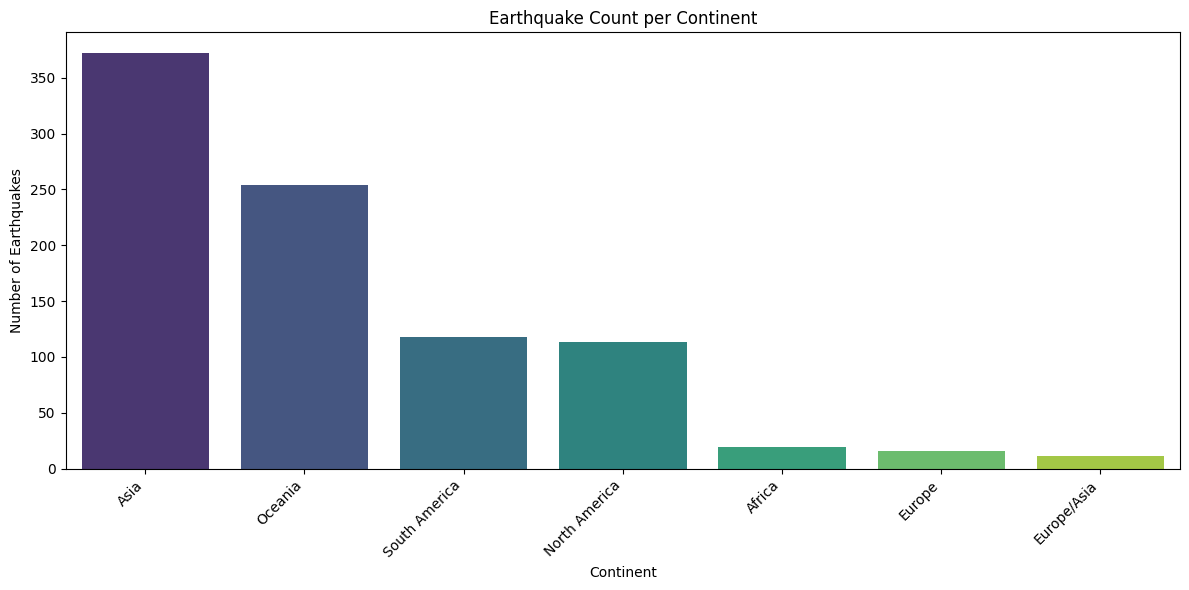

In [13]:
continent_counts = df['continent'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=continent_counts.index, y=continent_counts.values, palette='viridis')
plt.xlabel('Continent')
plt.ylabel('Number of Earthquakes')
plt.title('Earthquake Count per Continent')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Countries affected by Earthquake between 1995-2023

In [14]:
country_data = df.groupby('country').agg(
    earthquake_count=('country', 'size'),
    avg_magnitude=('magnitude', 'mean'),
    avg_latitude=('latitude', 'mean'),
    avg_longitude=('longitude', 'mean')
).reset_index()

fig = px.scatter_map(country_data,
                lat="avg_latitude", 
                lon="avg_longitude",
                color="earthquake_count", 
                hover_name="country", 
                zoom=0.0,
                map_style="open-street-map")
fig.show()

Year by year impact of Earthquake on countries between 1995-2023

In [15]:
country_data_year = df.groupby(['country', 'year']).agg(
    earthquake_count=('country', 'size'),
    avg_magnitude=('magnitude', 'mean'),
    avg_latitude=('latitude', 'mean'),
    avg_longitude=('longitude', 'mean')
).reset_index()
country_data_year = country_data_year.sort_values(by="year", ascending=True).reset_index()

fig = px.density_mapbox(country_data_year, lat="avg_latitude", lon="avg_longitude", mapbox_style="open-street-map",
                       animation_frame = 'year', zoom = 0.5, radius = 10)

fig.show()

/var/folders/sp/79r50f550zq9vtf04sjwdh2h0000gn/T/ipykernel_80652/202154045.py:9: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



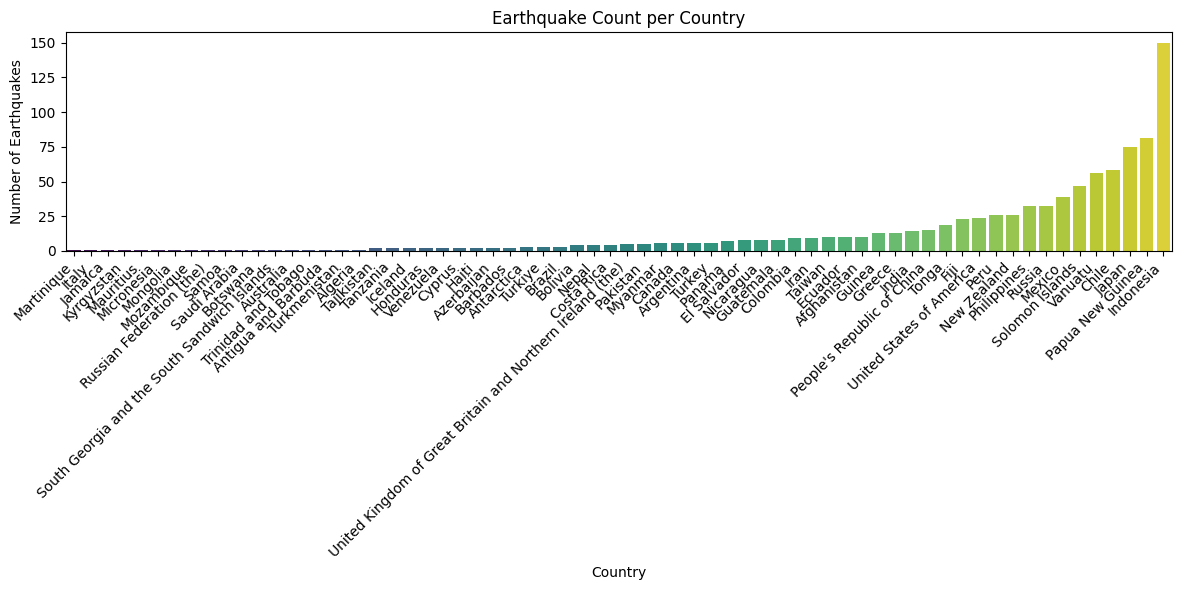

In [16]:
country_data = df.groupby('country').size().reset_index(name='earthquake_count')
country_data = country_data.sort_values(by="earthquake_count", ascending=True)
plt.figure(figsize=(12, 6))

sns.barplot(x=country_data["country"], y=country_data["earthquake_count"], hue=country_data["country"], palette='viridis', legend = False)

plt.xlabel('Country')
plt.ylabel('Number of Earthquakes')
plt.title('Earthquake Count per Country')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Now lets look at top 20 affected countries

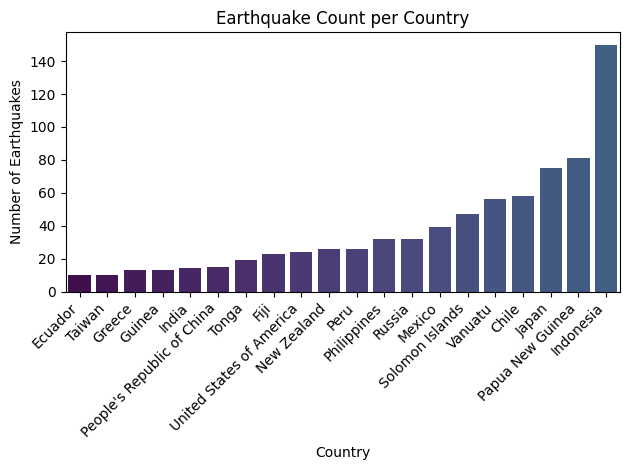

In [17]:
top_countries = country_data.nlargest(20, "earthquake_count")
top_countries = top_countries.sort_values(by="earthquake_count", ascending=True).reset_index()

sns.barplot(x=top_countries["country"], y=top_countries["earthquake_count"], hue=country_data["country"], palette='viridis', legend = False)
plt.xlabel('Country')
plt.ylabel('Number of Earthquakes')
plt.title('Earthquake Count per Country')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

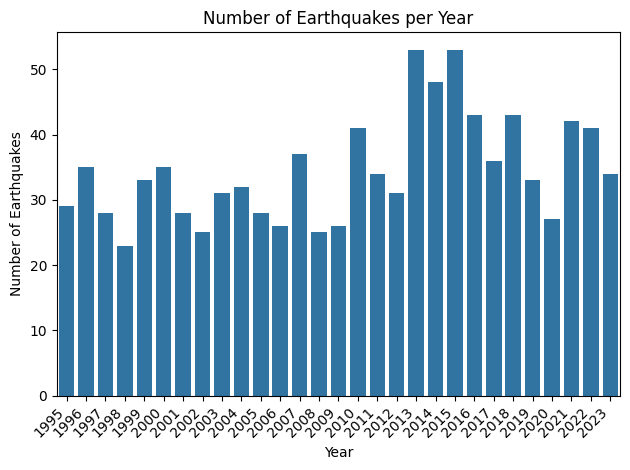

In [18]:
earthquakes_per_year = df.groupby('year').size()

sns.barplot(x=earthquakes_per_year.index, y=earthquakes_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.title('Number of Earthquakes per Year')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Magnitude

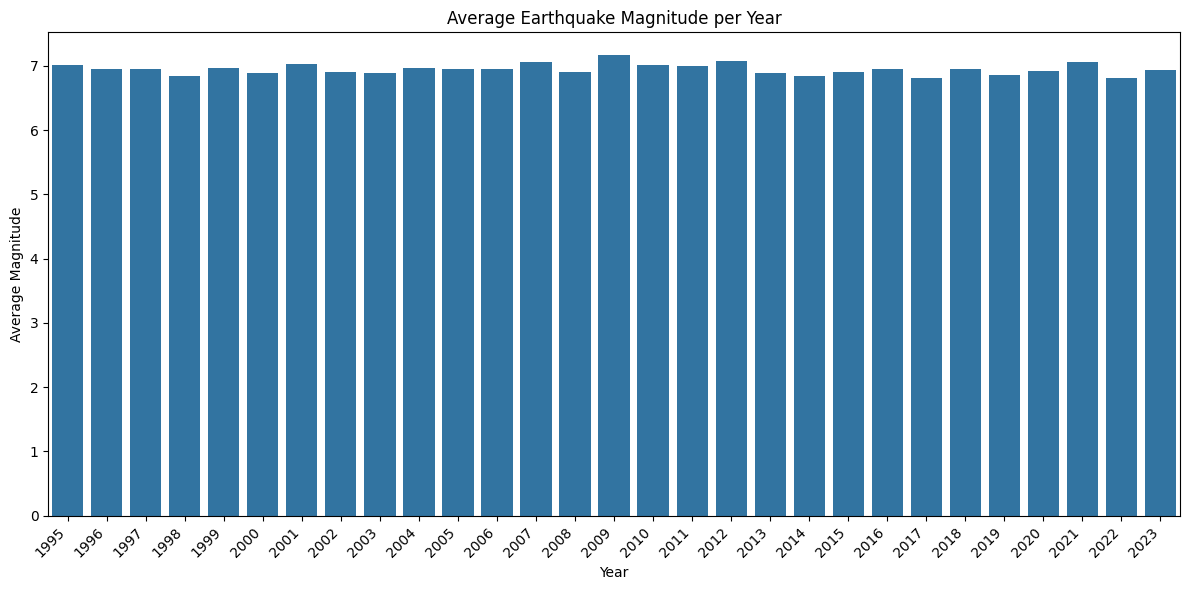

In [19]:
avg_magnitude_per_year = df.groupby('year')['magnitude'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_magnitude_per_year.index, y=avg_magnitude_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average Magnitude')
plt.title('Average Earthquake Magnitude per Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

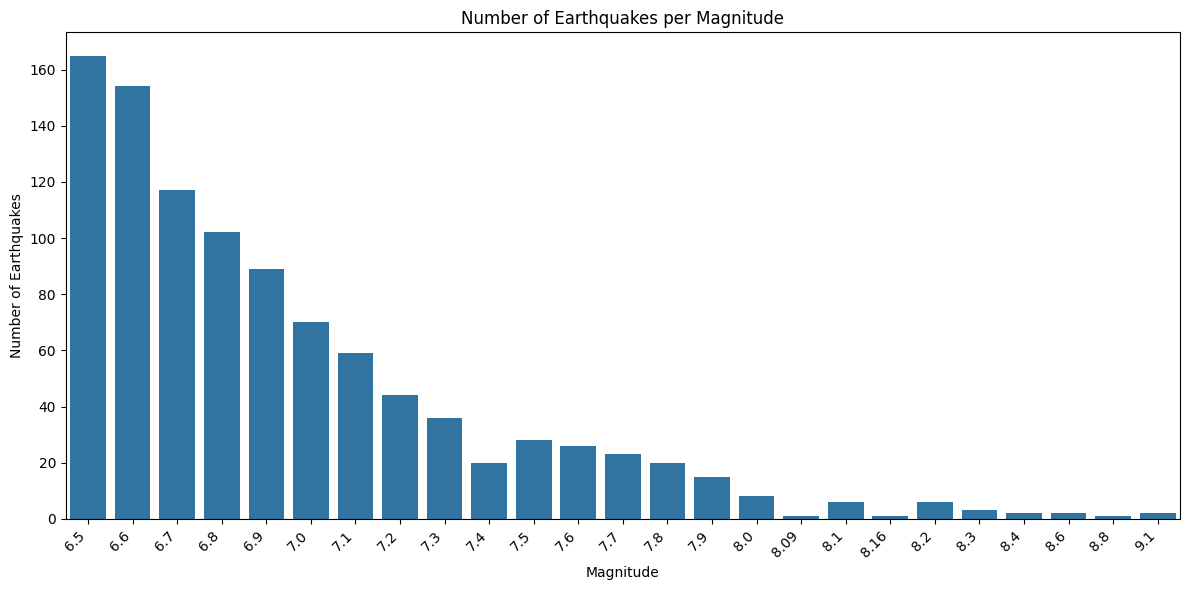

In [20]:
magnitude_counts = df['magnitude'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=magnitude_counts.index, y=magnitude_counts.values)
plt.xlabel('Magnitude')
plt.ylabel('Number of Earthquakes')
plt.title('Number of Earthquakes per Magnitude')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

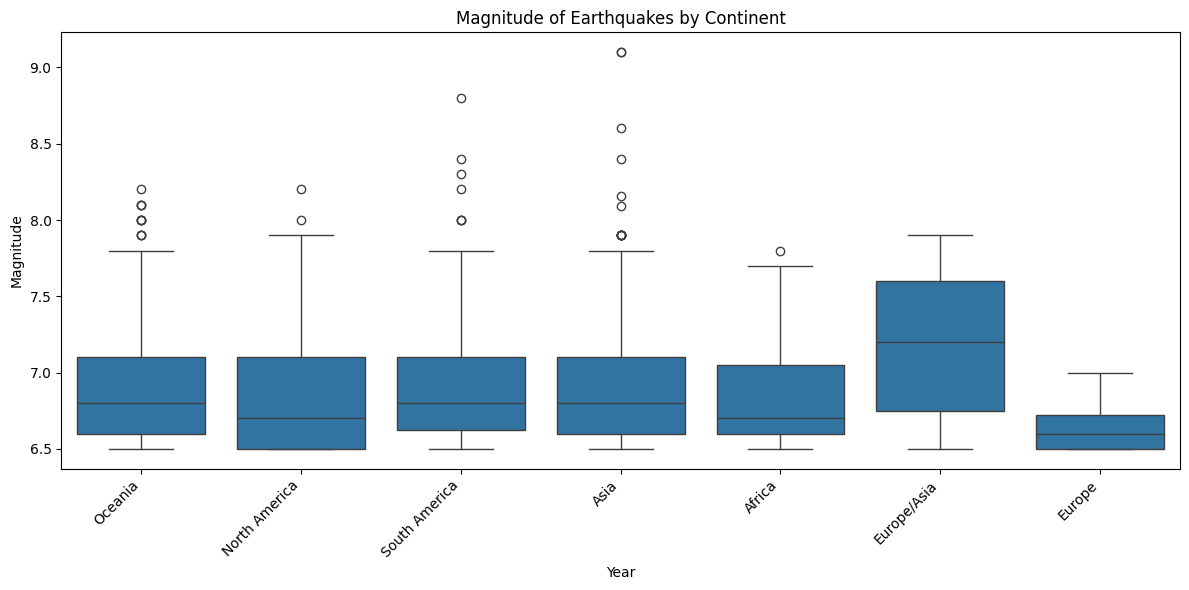

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='continent', y='magnitude', data=df)
plt.xlabel('Year')
plt.ylabel('Magnitude')
plt.title('Magnitude of Earthquakes by Continent')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

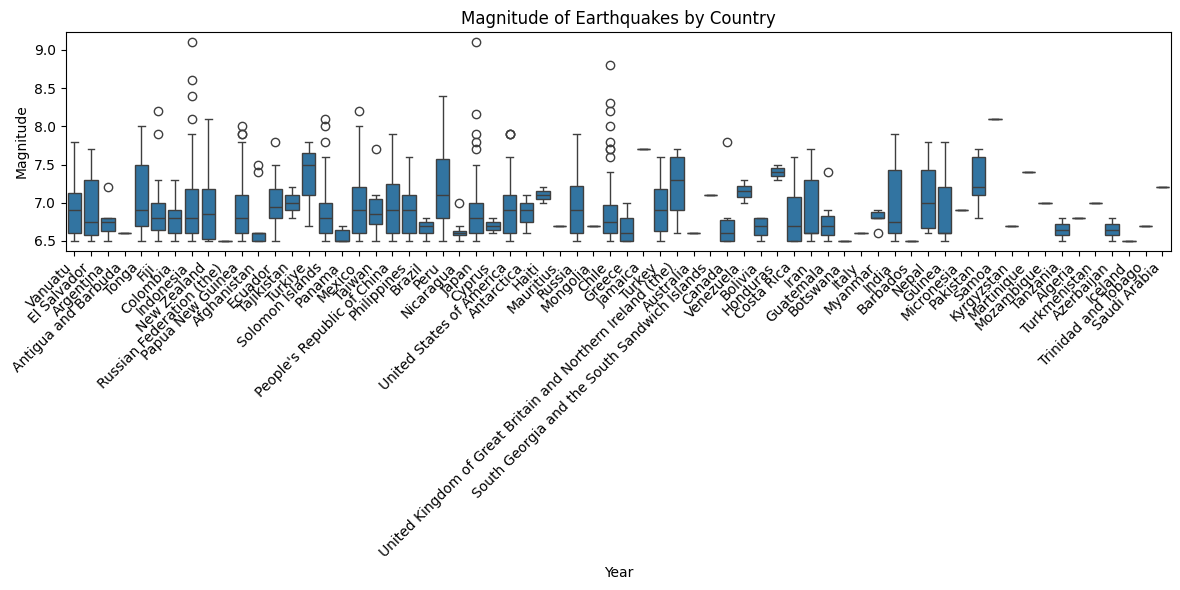

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='magnitude', data=df)
plt.xlabel('Year')
plt.ylabel('Magnitude')
plt.title('Magnitude of Earthquakes by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
fig = px.scatter_map(df, lat="latitude", lon="longitude", color="magnitude",
                        map_style="open-street-map", zoom = 0.0, color_continuous_scale = 'RdPu')

fig.show()

We observe that earthquake most occur near the Southern Port Cities

In [24]:
year_df = df.sort_values(by="year", ascending=True).reset_index()
fig = px.density_mapbox(year_df, lat="latitude", lon="longitude", mapbox_style="open-street-map",
                       animation_frame = 'year', zoom = 0.5, radius = 10)
fig.show()

/var/folders/sp/79r50f550zq9vtf04sjwdh2h0000gn/T/ipykernel_80652/3354951072.py:2: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### Tsunami

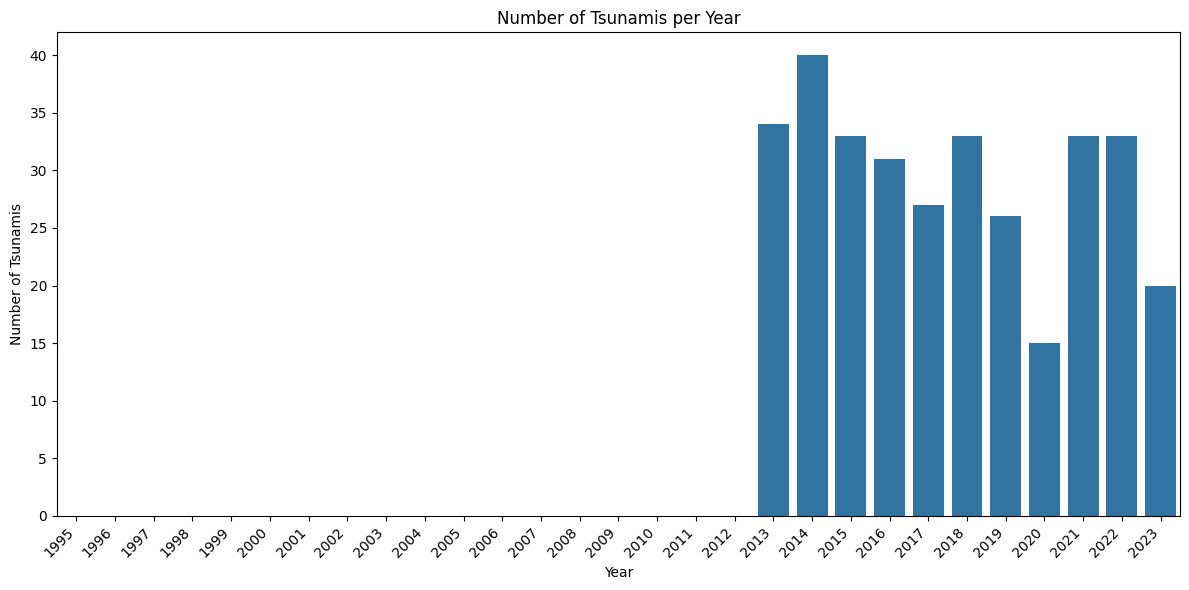

In [25]:
tsunami_per_year = df.groupby('year')['tsunami'].sum()

plt.figure(figsize=(12, 6))
sns.barplot(x=tsunami_per_year.index, y=tsunami_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Tsunamis')
plt.title('Number of Tsunamis per Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

It seems that tsunami data was only recorded starting from 2013.

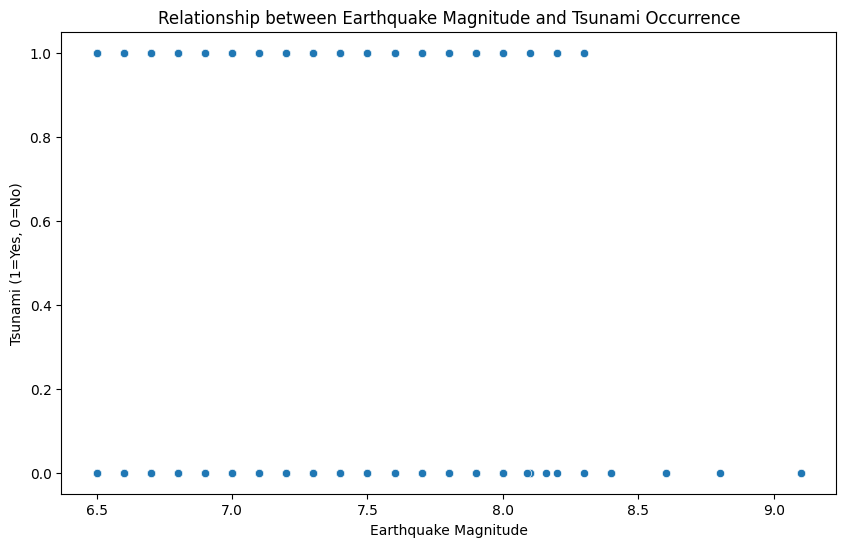

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='magnitude', y='tsunami', data=df)
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Tsunami (1=Yes, 0=No)')
plt.title('Relationship between Earthquake Magnitude and Tsunami Occurrence')
plt.show()

It can be observed that earthquakes with a magnitude less than 8.5 are associated with triggering tsunamis. However, there is limited evidence to support this correlation, as there are very few instances of earthquakes with magnitudes of 8.5 or greater.

### Depth


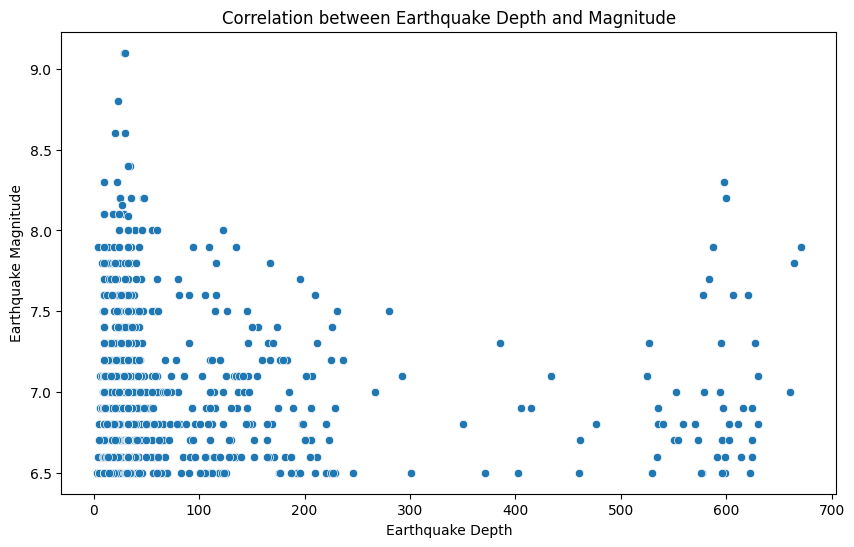


The correlation between depth and magnitude is: 0.017082664790508822


In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='depth', y='magnitude', data=df)
plt.xlabel('Earthquake Depth')
plt.ylabel('Earthquake Magnitude')
plt.title('Correlation between Earthquake Depth and Magnitude')
plt.show()

correlation = df['depth'].corr(df['magnitude'])
print(f"\nThe correlation between depth and magnitude is: {correlation}")

### Focusing on Indonesia

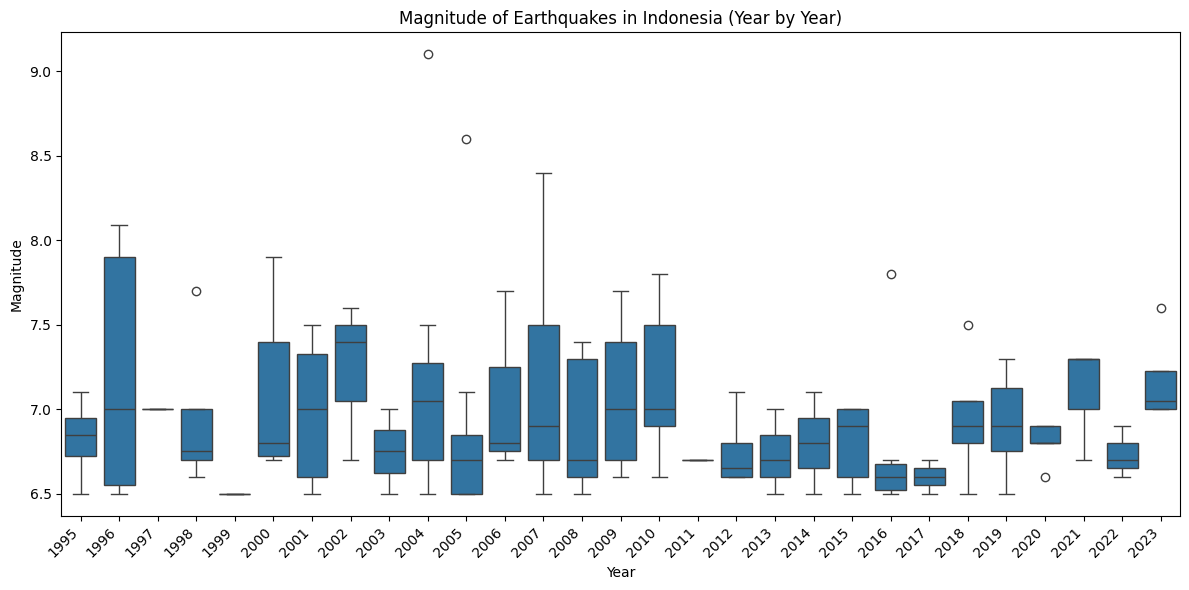

In [28]:
indonesia_df = df[df['country'] == 'Indonesia']

plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='magnitude', data=indonesia_df)
plt.xlabel('Year')
plt.ylabel('Magnitude')
plt.title('Magnitude of Earthquakes in Indonesia (Year by Year)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

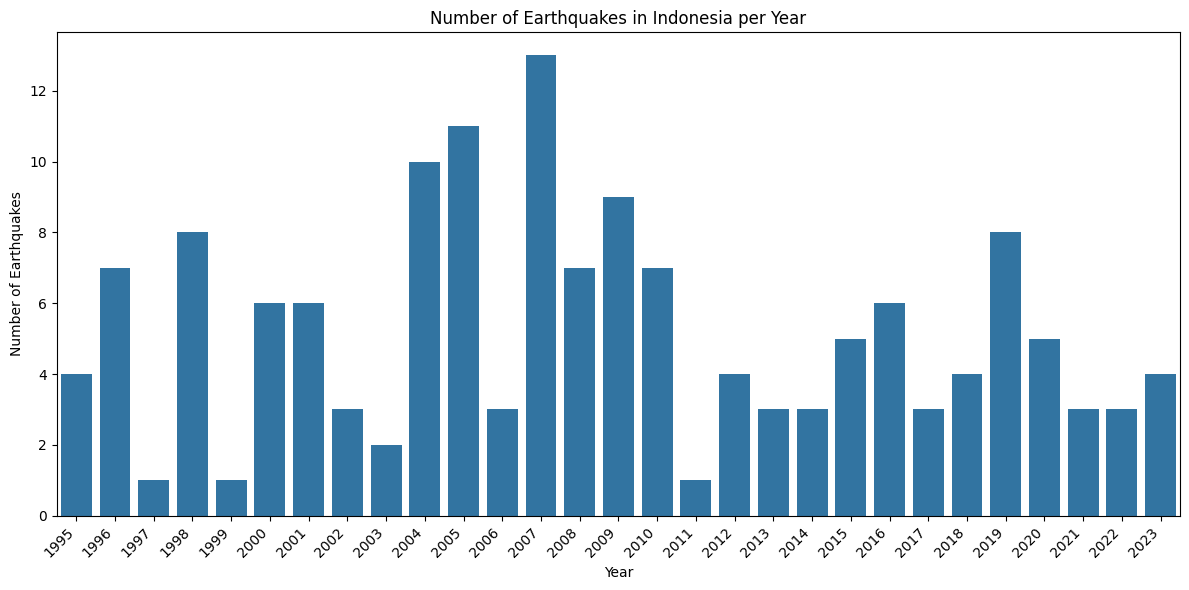

In [29]:
indonesia_earthquakes_by_year = indonesia_df.groupby('year').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=indonesia_earthquakes_by_year.index, y=indonesia_earthquakes_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.title('Number of Earthquakes in Indonesia per Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


We observe that the frequency of earthquakes in Indonesia has decreased in recent years, yet the average magnitude remains consistent. It would be interesting to explore whether the impact or damage to infrastructure has changed over time.

## Feature Engineering


Since sig is calculated based on magnitude, we will exclude sig from the modeling process.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      1000 non-null   object        
 1   magnitude  1000 non-null   float64       
 2   date_time  1000 non-null   datetime64[ns]
 3   cdi        1000 non-null   int64         
 4   mmi        1000 non-null   int64         
 5   alert      449 non-null    object        
 6   tsunami    1000 non-null   int64         
 7   sig        1000 non-null   int64         
 8   net        1000 non-null   object        
 9   nst        1000 non-null   int64         
 10  dmin       1000 non-null   float64       
 11  gap        1000 non-null   float64       
 12  magType    1000 non-null   object        
 13  depth      1000 non-null   float64       
 14  latitude   1000 non-null   float64       
 15  longitude  1000 non-null   float64       
 16  location   994 non-null    object        
 

In [31]:
df = df.drop(['sig', 'alert'], axis=1)

In [32]:
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour

In [33]:
label_encoder = LabelEncoder()

if 'magType' in df.columns:
    df['magType'] = label_encoder.fit_transform(df['magType'])

if 'country' in df.columns:
    df['country'] = label_encoder.fit_transform(df['country'])

if 'continent' in df.columns:
    df['continent'] = label_encoder.fit_transform(df['continent'])

In [34]:
df = df.dropna()

In [35]:
df.head()

,title,magnitude,date_time,cdi,mmi,tsunami,net,nst,dmin,gap,...,depth,latitude,longitude,location,country,continent,year,month,day,hour
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,2023-08-16 12:47:00,7,4,0,us,114,7.177000,25.0,...,192.955,-13.8814,167.1580,"Sola, Vanuatu",64,5,2023,8,16,12
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,2023-07-19 00:22:00,8,6,0,us,92,0.679000,40.0,...,69.727,12.8140,-88.1265,"Intipucá, El Salvador",17,4,2023,7,19,0
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,2023-07-17 03:05:00,7,5,0,us,70,1.634000,28.0,...,171.371,-38.1911,-70.3731,"Loncopué, Argentina",4,6,2023,7,17,3
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,2023-07-16 06:48:00,6,6,1,us,173,0.907000,36.0,...,32.571,54.3844,-160.6990,"Sand Point, Alaska",66,7,2023,7,16,6
4,M 7.3 - Alaska Peninsula,7.3,2023-07-16 06:48:00,0,5,1,at,79,0.879451,172.8,...,21.000,54.4900,-160.7960,Alaska Peninsula,66,7,2023,7,16,6


In [36]:
df.shape[0]

994

## Test Train Split Data

In [37]:
X = df[['cdi', 'mmi', 'tsunami', 'nst', 'dmin', 'depth', 'country', 'continent', 'year', 'month', 'day', 'hour']]
y = df['magnitude']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Machine Learning Model

In [39]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor()
}

# Step 3: Hyperparameter tuning
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'alpha': [0.1, 1, 10]
    },
    'Lasso Regression': {
        'alpha': [0.1, 1, 10]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10],
        'subsample': [0.7, 0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 6, 10],
        'num_leaves': [20, 23, 31]
    }
}

In [ ]:
best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    param_grid = param_grids[model_name]
    if len(param_grid) > 0:
        grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best params for {model_name}: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[model_name] = model

In [41]:
validation_scores = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    validation_scores[model_name] = mse
    print(f"{model_name} Validation MSE: {mse}")

Linear Regression Validation MSE: 0.1622628072166374
Ridge Regression Validation MSE: 0.16223582995201083
Lasso Regression Validation MSE: 0.16223523440267498
Decision Tree Validation MSE: 0.15768297173717188
Random Forest Validation MSE: 0.13717671396014308
XGBoost Validation MSE: 0.1391512441299317
LightGBM Validation MSE: 0.15262994944369276


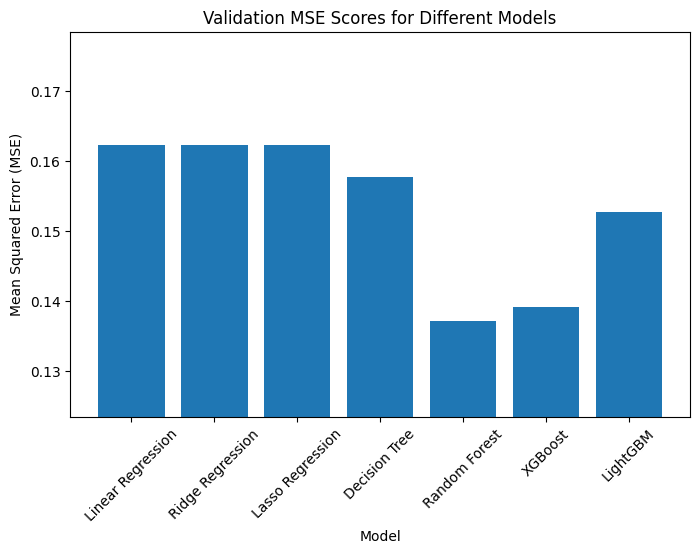

In [42]:
plt.figure(figsize=(8, 5))
plt.bar(validation_scores.keys(), validation_scores.values())
plt.xlabel("Model")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Validation MSE Scores for Different Models")
plt.xticks(rotation=45)
plt.ylim(min(validation_scores.values()) * 0.9, max(validation_scores.values()) * 1.1)

plt.show()

In [ ]:
voting_regressor = VotingRegressor(estimators=[(name, model) for name, model in best_models.items()])
voting_regressor.fit(X_train, y_train)

voting_pred = voting_regressor.predict(X_val)
voting_mse = mean_squared_error(y_val, voting_pred)
print(f"Voting Regressor Validation MSE: {voting_mse}")

In [44]:
best_model_name = min(validation_scores, key=validation_scores.get)
print(f"The best model on the validation set is {best_model_name} with MSE: {validation_scores[best_model_name]}")

The best model on the validation set is Random Forest with MSE: 0.13717671396014308


In [45]:
y_hat = best_models[best_model_name].predict(X_test)

mse_test = mean_squared_error(y_test, y_hat)

print(f"{best_model_name} Test MSE: {mse_test}")

Random Forest Test MSE: 0.13656322923675293
